In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import Imputer
from keras.utils import to_categorical
import sys

    
def prepare_input_df(data, is_training=True):    
    data.index = range(0, len(data))
    data = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

    # Make dummy variables for annotation
    one_hot_data = pd.concat([data, pd.get_dummies(data['Pclass'], prefix='Pclass'), pd.get_dummies(data['Sex'], prefix='Sex'), pd.get_dummies(data['Embarked'], prefix='Embarked') ], axis=1)

    # Drop the previous rank column
    one_hot_data = one_hot_data.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

    one_hot_data[:10]
    data = one_hot_data

    # imputing missing values
    data.loc[~data['Cabin'].isnull(), ['Cabin']] = 1
    data.loc[data['Cabin'].isnull(), ['Cabin']] = 0
    
    data.loc[data['Age'].isnull(), ['Age']] = data['Age'].max()
    

    ## replace YES with 1 and NO with 0 and store to 'y'
    # label_mapping = {'YES': 1, 'NO': 0}
    # data = data.replace({'Survived': label_mapping})

    if is_training:
        y = data['Survived']
        
    # imputing missing values
    fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=1)
    imputed_DF = pd.DataFrame(fill_NaN.fit_transform(data))
    imputed_DF.columns = data.columns
    data.index = data.index
    data = imputed_DF
    # data = data.interpolate(method='spline', order=2) # interpolate missing values
    #data = data.fillna(0)

    # normalise data
    data = (data - data.min()) / (data.max() - data.min())

    
    if is_training:
        data['Survived'] = y
    
    return data

data = pd.read_csv('../input/train.csv', sep=',')
data = prepare_input_df(data)

data[:10]

# test = pd.read_csv('test.csv', sep=',')
# test_data = prepare_input_df(test, False)
# test_data[:10]



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


,Survived,Age,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,0.271174,0.125,0.000000,0.014151,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,0.472229,0.125,0.000000,0.139136,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,0.321438,0.000,0.000000,0.015469,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,0.434531,0.125,0.000000,0.103644,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,0.434531,0.000,0.000000,0.015713,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5,0,1.000000,0.000,0.000000,0.016510,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,0,0.673285,0.000,0.000000,0.101229,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,0,0.019854,0.375,0.166667,0.041136,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
8,1,0.334004,0.000,0.333333,0.021731,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
9,1,0.170646,0.125,0.000000,0.058694,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [2]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras import regularizers
from keras.metrics import categorical_accuracy
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(init_mode='he_normal'):
    
    reglr = 0.001
    # Building the model
    model = Sequential()

    model.add(Dense(64, kernel_initializer=init_mode, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(reglr) ))
    model.add(Dropout(.4))

    model.add(Dense(32, kernel_initializer=init_mode, activation='relu', kernel_regularizer=regularizers.l2(reglr)))
    model.add(Dropout(.4))
    
    model.add(Dense(16, kernel_initializer=init_mode, activation='relu', kernel_regularizer=regularizers.l2(reglr)))
    model.add(Dropout(.4))
    
    model.add(Dense(2, activation='softmax'))

    # Compiling the model
    # sgd_optim = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
    # adam=keras.optimizers.Adam(lr=0.00001)
          
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)
# model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
model

### Train model using (optimal) selected parameters

In [3]:
# # # Split X into training and test sets
sample = np.random.choice(data.index, size=int(len(data)*0.7), replace=False)
train_data, test_data = data.iloc[sample], data.drop(sample)

X_train = np.array(train_data.drop('Survived', axis=1))
y_train = np.array(keras.utils.to_categorical(train_data['Survived'], 2))

X_test = np.array(test_data.drop('Survived', axis=1))
y_test = np.array(keras.utils.to_categorical(test_data['Survived'], 2))

In [4]:
from keras.callbacks import ModelCheckpoint   

# Creating the model
model = create_model()

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

# Fit the model
# early_stopping = [EarlyStopping(monitor='acc', patience=2)] # do not apply without checking
out = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, 
                validation_split=0.1, callbacks=[checkpointer])


Epoch 00001: val_loss improved from inf to 0.78424, saving model to model.weights.best.hdf5

Epoch 00002: val_loss improved from 0.78424 to 0.74922, saving model to model.weights.best.hdf5

Epoch 00003: val_loss improved from 0.74922 to 0.73696, saving model to model.weights.best.hdf5

Epoch 00004: val_loss improved from 0.73696 to 0.73273, saving model to model.weights.best.hdf5

Epoch 00005: val_loss improved from 0.73273 to 0.71165, saving model to model.weights.best.hdf5

Epoch 00006: val_loss improved from 0.71165 to 0.69778, saving model to model.weights.best.hdf5

Epoch 00007: val_loss improved from 0.69778 to 0.69092, saving model to model.weights.best.hdf5

Epoch 00008: val_loss improved from 0.69092 to 0.67653, saving model to model.weights.best.hdf5

Epoch 00009: val_loss improved from 0.67653 to 0.66376, saving model to model.weights.best.hdf5

Epoch 00010: val_loss improved from 0.66376 to 0.65272, saving model to model.weights.best.hdf5

Epoch 00011: val_loss improved fr

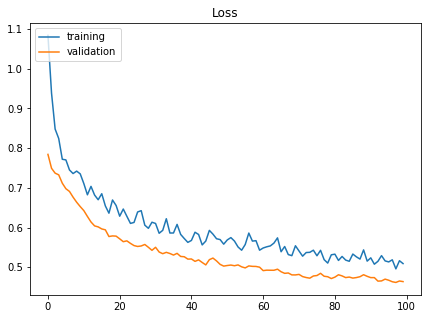

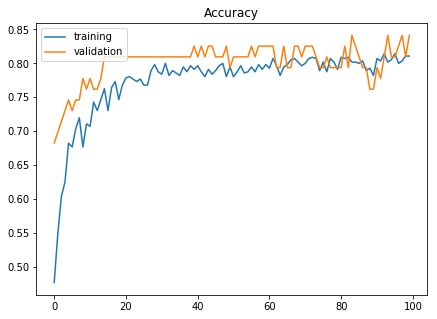

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = np.array(out.__dict__['epoch'])
acc = np.array(out.__dict__['history']['acc'])
loss = np.array(out.__dict__['history']['loss'])
val_acc = np.array(out.__dict__['history']['val_acc'])
val_loss = np.array(out.__dict__['history']['val_loss'])

f = plt.figure(figsize=(7,5))
plt.plot(epochs, loss, label='training')
plt.plot(epochs, val_loss, label='validation')
plt.legend(loc='upper left')
plt.title('Loss')

plt.show()

f = plt.figure(figsize=(7,5))
plt.plot(epochs, acc, label='training')
plt.plot(epochs, val_acc, label='validation')
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.show()

f.savefig("train_validation_loss.pdf", bbox_inches='tight')

### Load the weights that yielded the best validation accuracy

In [6]:
model.load_weights('model.weights.best.hdf5')

#### Evaluating the model on the training and testing set

In [7]:
train_score = model.evaluate(X_train, y_train, verbose=1)
print("\n Training Accuracy:", train_score[1])
test_score = model.evaluate(X_test, y_test, verbose=1)
print("\n Testing Accuracy:", test_score[1])

623/623 [==============================] - 0s 122us/step

 Training Accuracy: 0.813804173642
268/268 [==============================] - 0s 41us/step

 Testing Accuracy: 0.835820896412


In [8]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
# y_pred = y.values.argmax

y_pred = model.predict_classes(X_test)

p = model.predict_proba(X_test)

print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
print()
TN, FP, FN, TP = confusion_matrix(np.argmax(y_test, axis=1), y_pred).ravel()
print("TP:", TP)
print("FN:", FN)
print("TN:", TN)
print("FP:", FP)

             precision    recall  f1-score   support

          0       0.82      0.95      0.88       172
          1       0.87      0.64      0.73        96

avg / total       0.84      0.84      0.83       268

[[163   9]
 [ 35  61]]

TP: 61
FN: 35
TN: 163
FP: 9


In [9]:
conc = pd.concat([pd.DataFrame(y_test), pd.DataFrame(p)], axis=1)
conc.columns = ['test_0', 'test_1', 'pred_0', 'pred_1']
subdf = conc.loc[conc['test_1'] == 1]
subdf.loc[subdf['pred_1'] >= 0.5][:5]

,test_0,test_1,pred_0,pred_1
0,0.0,1.0,0.017759,0.982241
3,0.0,1.0,0.107226,0.892774
10,0.0,1.0,0.040161,0.959839
11,0.0,1.0,0.372594,0.627406
16,0.0,1.0,0.021244,0.978756


### Predict on unseen data

In [10]:
test = pd.read_csv('../input/test.csv', sep=',')
subm_test_data = prepare_input_df(test, False)

In [11]:
subm_test_data[:5]

y_pred = model.predict_classes(subm_test_data)
p = model.predict_proba(subm_test_data)
p[:10]

array([[ 0.86154592,  0.13845408],
       [ 0.68966639,  0.31033364],
       [ 0.86845928,  0.13154067],
       [ 0.83152366,  0.16847634],
       [ 0.64375848,  0.35624149],
       [ 0.81778359,  0.18221638],
       [ 0.46993023,  0.53006983],
       [ 0.83903849,  0.16096151],
       [ 0.35613707,  0.6438629 ],
       [ 0.8422749 ,  0.15772513]], dtype=float32)

In [12]:
df = pd.DataFrame(p)
df.columns = ['pred0', 'pred1']
df[:20]

,pred0,pred1
0,0.861546,0.138454
1,0.689666,0.310334
2,0.868459,0.131541
3,0.831524,0.168476
4,0.643758,0.356241
5,0.817784,0.182216
6,0.469930,0.530070
7,0.839038,0.160962
8,0.356137,0.643863
9,0.842275,0.157725


In [13]:
comp = df.pred0 < df.pred1
comp[:20]
type(comp)

pandas.core.series.Series

In [14]:
with open("titanic_submission.csv", "w") as f: 
    f.write("PassengerId,Survived\n")
    
    for i in range(len(comp)):
        f.write(str(i + 892) + ',' + str(int(comp[i])) + "\n")